### Original size

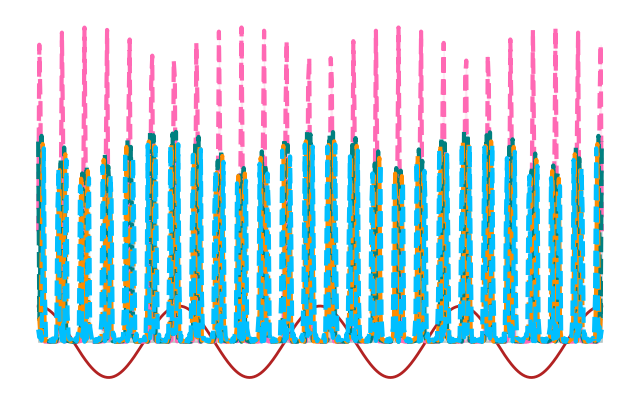

In [97]:
from matplotlib.figure import figaspect
import matplotlib.pyplot as plt
import numpy as np
from tools.fix_phase import fix_phase


def phi(x, n, theta):
    return np.exp(-1j * 2 * n * np.pi * x / theta)


def H(E, theta, n=10):
    hmat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            hmat[i, j] = h(E, theta, i + 1e-5, j)
    return hmat


# def h(E, theta, i, j):
#     e = (
#         (1 + 2 * j + 8 * j**2 * E**2)
#         * np.sin((i - j) * np.pi)
#         / ((i - j) * theta**2)
#     )
#     e -= (
#         (1 + 2 * j + 8 * j**2 * E**2)
#         * np.sin((2 + i + j) * np.pi)
#         / ((2 + i + j) * theta**2)
#     )
#     b = -np.sin(np.pi * (i - j - theta) / (i - j - 2 * theta))
#     b += np.sin(np.pi * (2 + i + j - theta) / (2 + i + j - 2 * theta))
#     b += np.sin(np.pi * theta) / (i - j - 2 * theta)
#     b -= np.sin(np.pi * theta) / (2 + i + j - 2 * theta)
#     b -= np.sin(np.pi * theta) / (i - j + 2 * theta)
#     b += np.sin(np.pi * theta) / (2 + i + j + 2 * theta)
#     b -= np.sin(np.pi * (i - j + theta) / (i - j + 2 * theta))
#     b += np.sin(np.pi * (2 + i + j + theta) / (2 + i + j + -2 * theta))
#     e += 4 * E**2 * b
#     return e


def h(E, a, m, n):
    e = a * (2 * n**2 * np.pi**2 * ((m - n) ** 2 - 1) + E**2)
    e *= np.sin(2 * (m - n) * np.pi) / ((m - n) * np.pi)
    e /= (m - n) ** 2 - 1
    return e


L = 4
Nb = 10
hb = 6.62607015e-34 / (2 * np.pi)
m = 6 * 1.66053907e-27
V0 = 2 * np.pi * 52.26e3
e = np.sqrt(m * V0 / (2 * hb))
a = 1
E, W = np.linalg.eigh(H(e, a, Nb))
E = hb * E / (m * V0)
E = E[:L]
W = W[:, :L]

fig, ax = plt.subplots(figsize=(8, 5))


# Plot total potential
x = np.linspace(-L * np.pi, L * np.pi, 500)
v = np.cos(x) - 1
plt.plot(x, v, "-", label="V", lw=2, color="firebrick")
vmin = np.min(v[:180])

x = np.linspace(-L * np.pi, L * np.pi, 500)
p = np.array([]).reshape(0, 500)
for i in range(Nb):
    p = np.append(p, phi(x, i, a)[None], axis=0)
wf = abs(fix_phase(np.dot(p.T, W)))**2 - 1

color = ["hotpink", "teal", "darkorange", "deepskyblue"]
for i in range(L):
    shade_alpha = 0.1
    line_alpa = 1
    line_shape = "--"
    plt.plot(
        x,
        wf[:, i],
        line_shape,
        lw=3,
        color=color[i],
        label=f"$w_{i + 1}(x)$",
        alpha=line_alpa,
    )
    plt.fill_between(x, -1, wf[:, i], color=color[i], alpha=shade_alpha)

plt.xlabel("dx")
# plt.ylim(-1.4, .3)
plt.axis("off")
plt.savefig("fig0a.svg", transparent=True, bbox_inches="tight")


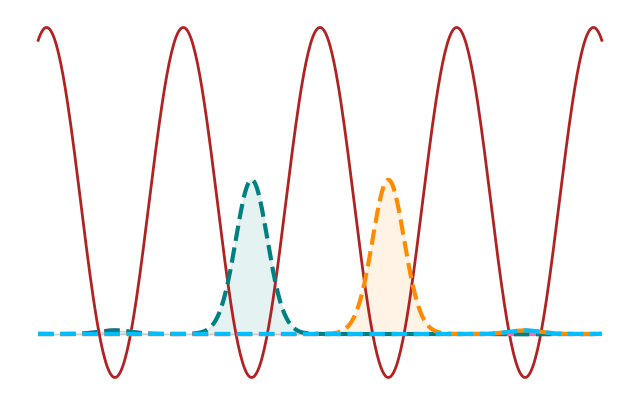

In [4]:
from matplotlib.figure import figaspect
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
edge = 0.6
wf_scale = 0.5
pwr = 1

y = np.array([0])
z = np.array([0])
taillen = 1.2

# Plot total potential
x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
X = np.meshgrid(x, y, z, indexing="ij")
v = dvr.Vfun(*X) ** pwr
v = -abs(v[:, 0, 0])
plt.plot(x, v, "-", label="V", lw=2, color="firebrick")
vmin = np.min(v[:180])
vi_scale = -np.sqrt(abs(vmin))
vi_scale = -1
# plt.fill_between(x[v < vmin], vmin, v[v < vmin], color="firebrick", alpha=0.3)

# # Plot single traps
# for i in range(dvr.lattice.N):
#     opacity = 0.3
#     shift = dvr.trap_centers[i]
#     dvr.update_waist(dvr.waists[i])
#     x = np.linspace(shift[0] - taillen, shift[0] + taillen, 500)
#     X = np.meshgrid(x, y, z, indexing="ij")
#     vi = dvr.Voff[i] * DVR.Vfun(dvr, X[0] - shift[0], X[1] - shift[1], X[2]) ** pwr
#     plt.plot(
#         x,
#         vi_scale * abs(vi[:, 0, 0]),
#         "-",
#         label="V",
#         lw=2,
#         color="orange",
#         alpha=opacity,
#     )

color = ["hotpink", "teal", "darkorange", "deepskyblue"]
x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
wf = wf_scale * fix_phase(wannier_func([x, y, z], U, dvr, W, p)[:, 0, 0, :]) + E[0]
for i in range(dvr.lattice.N):
    shade_alpha = 0.1
    line_alpa = 1
    line_shape = "--"
    plt.plot(
        x,
        wf[:, i],
        line_shape,
        lw=3,
        color=color[i],
        label=f"$w_{i + 1}(x)$",
        alpha=line_alpa,
    )
    plt.fill_between(x, E[0], wf[:, i], color=color[i], alpha=shade_alpha)

plt.xlabel("dx")
# plt.ylim(-1.4, .3)
plt.axis("off")
plt.savefig("fig0b.svg", transparent=True, bbox_inches="tight")


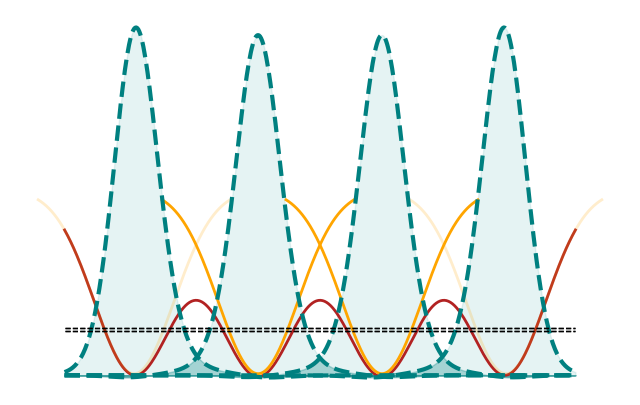

In [50]:
from matplotlib.figure import figaspect
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
edge = 0.6
wf_scale = 1
pwr = 1

y = np.array([0])
z = np.array([0])
taillen = 1.2

# Plot total potential
x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
X = np.meshgrid(x, y, z, indexing="ij")
v = dvr.Vfun(*X) ** pwr
v = -abs(v[:, 0, 0])
plt.plot(x, v, "-", label="V", lw=2, color="firebrick")
vmin = np.min(v[:180])
vi_scale = -np.sqrt(abs(vmin))
vi_scale = -1
plt.fill_between(x[v < vmin], vmin, v[v < vmin], color="firebrick", alpha=0.3)

# Plot single traps
for i in range(dvr.lattice.N):
    opacity = 1
    if i in [0, dvr.lattice.N - 1]:
        opacity /= 5
    shift = dvr.trap_centers[i]
    dvr.update_waist(dvr.waists[i])
    x = np.linspace(shift[0] - taillen, shift[0] + taillen, 500)
    X = np.meshgrid(x, y, z, indexing="ij")
    vi = dvr.Voff[i] * DVR.Vfun(dvr, X[0] - shift[0], X[1] - shift[1], X[2]) ** pwr
    plt.plot(
        x,
        vi_scale * abs(vi[:, 0, 0]),
        "-",
        label="V",
        lw=2,
        color="orange",
        alpha=opacity,
    )

x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
wf = wf_scale * fix_phase(wannier_func([x, y, z], U, dvr, W, p)[:, 0, 0, :]) + vmin
for i in range(dvr.lattice.N):
    shade_alpha = 0.1
    line_alpa = 1
    line_shape = "--"
    plt.plot(
        x,
        wf[:, i],
        line_shape,
        lw=3,
        color="teal",
        label=f"$w_{i + 1}(x)$",
        alpha=line_alpa,
    )
    plt.fill_between(x, vmin, wf[:, i], color="darkcyan", alpha=shade_alpha)
for i in dvr.lattice.links:
    plt.fill_between(
        x,
        vmin,
        np.min(np.array([wf[:, i[0]], wf[:, i[1]]]), axis=0),
        color="teal",
        alpha=0.2,
    )

for Ei in E:
    plt.plot(x, np.ones_like(x) * Ei, "--", color="black", lw=1)

plt.xlabel("dx")
plt.axis('off')
plt.savefig("fig1c.svg", transparent=True, bbox_inches="tight")


We plot the energy level of 1st excited bands in the 3D system, and we find that the levels are pretty near the barrier in the trap. This means that the higher excited bands might not be well localized in each trap.

### Figure 1a

In [13]:
from Hubbard.core import *
import numpy as np
from tools.fix_phase import fix_phase
import numpy.linalg as la

N = 20
L = 1
R0 = np.array([3, 3, 7.2])
dvr = MLWF(
    N,
    R0=R0,
    lattice=np.array([L], dtype=int),
    trap=(50, 1000),
    lc=(1800,),
    dim=1,
    sparse=True,
    symmetry=True,
    verbosity=0,
)

E, W, parity = dvr.eigen_basis()
E = E[0]
W = W[0]
p = parity[0]

A, U = singleband_WF(dvr, E, W, p)
print("detU =", la.det(U))
V = singleband_interaction(dvr, U, U, W, W, p, p)
print(dvr.R0[0] * 0.6)


Lattice: lattice shape is square; lattice constants set to: (1800, 1800)
detU = 1.0
1.7999999999999998


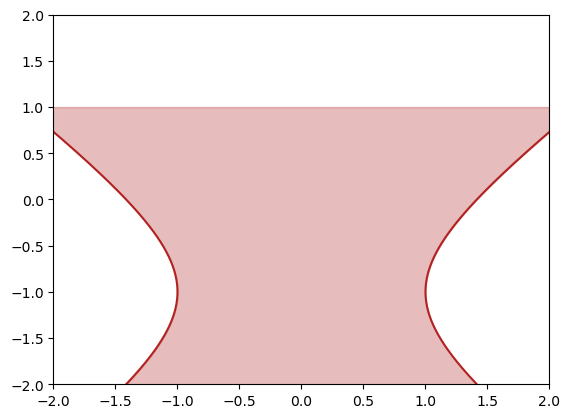

In [18]:
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt
import numpy as np

xlim = 2
a = 1
x = np.linspace(-2, 2, 500)
u = np.sqrt((x / a) ** 2 + 1)
d = -np.sqrt((x / a) ** 2 + 1)
base = plt.gca().transData
rot = Affine2D().rotate_deg(90).translate(0, -1)
plt.xlim(-xlim, xlim)
plt.ylim(-xlim, xlim)
plt.fill_between(x, u, d, transform=rot + base, color="firebrick", alpha=0.3)

plt.plot(x, u, transform=rot + base, color="firebrick")
plt.plot(x, d, transform=rot + base, color="firebrick")


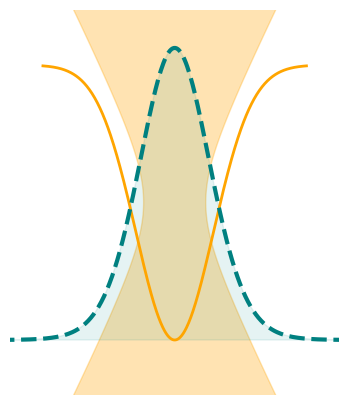

In [47]:
from matplotlib.transforms import Affine2D
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4.25, 5))
edge = 0.5
wf_scale = 0.8
pwr = 2

y = np.array([0])
z = np.array([0])
taillen = 1.2
vi_scale = -1

xlim = dvr.R0[0] * edge

# Plot single traps
for i in range(dvr.lattice.N):
    opacity = 1
    shift = dvr.trap_centers[i]
    dvr.update_waist(dvr.waists[i])
    x = np.linspace(shift[0] - taillen, shift[0] + taillen, 500)
    X = np.meshgrid(x, y, z, indexing="ij")
    vi = dvr.Voff[i] * DVR.Vfun(dvr, X[0] - shift[0], X[1] - shift[1], X[2]) ** pwr
    plt.plot(
        x,
        vi_scale * abs(vi[:, 0, 0]),
        "-",
        label="V",
        lw=2,
        color="orange",
        alpha=opacity,
    )
vmin = np.min(vi_scale * abs(vi[:, 0, 0]))

beam_center = 0.5 * vmin
base = plt.gca().transData
rot = Affine2D().rotate_deg(90).translate(0, beam_center)
a = 0.8
b = 0.08
beam_alpha = 0.3
x = np.linspace(-dvr.R0[0], dvr.R0[0], 500)
u = np.sqrt((x / a) ** 2 + b)
d = -np.sqrt((x / a) ** 2 + b)
plt.fill_between(x, u, d, transform=rot + base, color="orange", alpha=beam_alpha)

wf = wf_scale * fix_phase(wannier_func([x, y, z], U, dvr, W, p)[:, 0, 0, :]) + vmin
for i in range(dvr.lattice.N):
    shade_alpha = 0.1
    line_alpa = 1
    line_shape = "--"
    plt.plot(
        x,
        wf[:, i],
        line_shape,
        lw=3,
        color="teal",
        label=f"$w_{i + 1}(x)$",
        alpha=line_alpa,
    )
    plt.fill_between(x, vmin, wf[:, i], color="darkcyan", alpha=shade_alpha)
for i in dvr.lattice.links:
    plt.fill_between(
        x,
        vmin,
        np.min(np.array([wf[:, i[0]], wf[:, i[1]]]), axis=0),
        color="teal",
        alpha=0.2,
    )

plt.xlim(-xlim, xlim)
ytail = 0.7
plt.ylim(beam_center - ytail, beam_center + ytail)

plt.xlabel("dx")
plt.axis("off")
plt.savefig("fig1a.svg", transparent=True, bbox_inches="tight")


### Figure 1b

In [1]:
from Hubbard.equalizer import *
import numpy as np
from tools.fix_phase import fix_phase
import numpy.linalg as la

N = 20
L = 2
R0 = np.array([3, 3, 7.2])
dvr = HubbardEqualizer(
    N,
    R0=R0,
    lattice=np.array([L], dtype=int),
    trap=(50, 1000),
    lc=(1350,),
    dim=1,
    equalize_V0=False,
    sparse=True,
    symmetry=True,
    verbosity=0,
)

E, W, parity = dvr.eigen_basis()
E = E[0]
W = W[0]
p = parity[0]

A, U = singleband_WF(dvr, E, W, p)
print("detU =", la.det(U))
V = singleband_interaction(dvr, U, U, W, W, p, p)
print(dvr.R0[0])


Lattice: lattice shape is square; lattice constants set to: (1350, 1350)
Equalize: scale_factor is not a number. Set to None.
Equalize: ghost sites are set.
detU = -0.9999999999999999
3.675


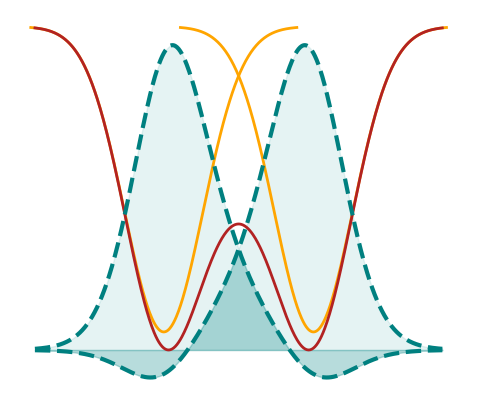

In [5]:
from matplotlib.figure import figaspect
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5.9, 5))
edge = 0.5
wf_scale = 0.8
pwr = 2

y = np.array([0])
z = np.array([0])
taillen = 1.2

# Plot total potential
x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
X = np.meshgrid(x, y, z, indexing="ij")
v = dvr.Vfun(*X) ** pwr
v = -abs(v[:, 0, 0])
vmin = np.min(v[:180])
vi_scale = -1
plt.fill_between(x[v < vmin], vmin, v[v < vmin], color="firebrick", alpha=0.3)

# Plot single traps
for i in range(dvr.lattice.N):
    opacity = 1
    shift = dvr.trap_centers[i]
    dvr.update_waist(dvr.waists[i])
    x = np.linspace(shift[0] - taillen, shift[0] + taillen, 500)
    X = np.meshgrid(x, y, z, indexing="ij")
    vi = dvr.Voff[i] * DVR.Vfun(dvr, X[0] - shift[0], X[1] - shift[1], X[2]) ** pwr
    plt.plot(
        x,
        vi_scale * abs(vi[:, 0, 0]),
        "-",
        label="V",
        lw=2,
        color="orange",
        alpha=opacity,
    )

x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
plt.plot(x, v, "-", label="V", lw=2, color="firebrick")

wf = wf_scale * fix_phase(wannier_func([x, y, z], U, dvr, W, p)[:, 0, 0, :]) + vmin
for i in range(dvr.lattice.N):
    shade_alpha = 0.1
    line_alpa = 1
    line_shape = "--"
    plt.plot(
        x,
        wf[:, i],
        line_shape,
        lw=3,
        color="teal",
        label=f"$w_{i + 1}(x)$",
        alpha=line_alpa,
    )
    plt.fill_between(x, vmin, wf[:, i], color="darkcyan", alpha=shade_alpha)
for i in dvr.lattice.links:
    plt.fill_between(
        x,
        vmin,
        np.min(np.array([wf[:, i[0]], wf[:, i[1]]]), axis=0),
        color="teal",
        alpha=0.2,
    )

plt.xlabel("dx")
plt.axis("off")
plt.savefig("fig1b.svg", transparent=True, bbox_inches="tight")


### Figure 1c

In [48]:
from Hubbard.equalizer import *
import numpy as np
from tools.fix_phase import fix_phase
import numpy.linalg as la

N = 20
L = 3
R0 = np.array([3, 3, 7.2])
dvr = HubbardEqualizer(
    N,
    R0=R0,
    lattice=np.array([L], dtype=int),
    trap=(50, 1000),
    lc=(1350,),
    dim=1,
    equalize_V0=False,
    sparse=True,
    symmetry=True,
    verbosity=0,
)

E, W, parity = dvr.eigen_basis()
E = E[0]
W = W[0]
p = parity[0]

A, U = singleband_WF(dvr, E, W, p)
print("detU =", la.det(U))
V = singleband_interaction(dvr, U, U, W, W, p, p)
print(dvr.R0[0] * edge)


Lattice: lattice shape is square; lattice constants set to: (1350, 1350)
Equalize: scale_factor is not a number. Set to None.
Equalize: ghost sites are set.
detU = 0.9999999999999999
2.175


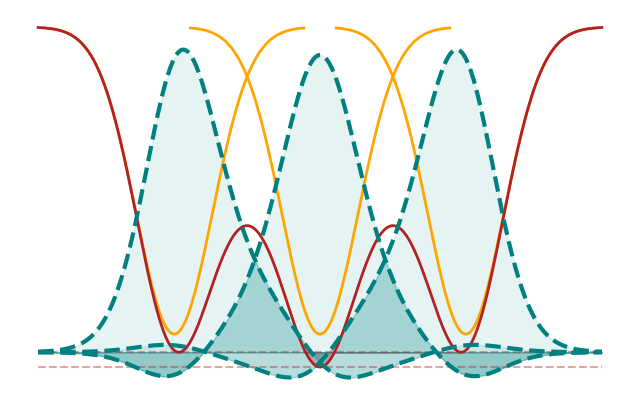

In [52]:
from matplotlib.figure import figaspect
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
edge = 0.6
wf_scale = 0.8
pwr = 2

y = np.array([0])
z = np.array([0])
taillen = 1.2

# Plot total potential
x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
X = np.meshgrid(x, y, z, indexing="ij")
v = dvr.Vfun(*X) ** pwr
v = -abs(v[:, 0, 0])
vmin = np.min(v[:180])
vmmin = np.min(v)
vi_scale = -1

# Plot single traps
for i in range(dvr.lattice.N):
    opacity = 1
    shift = dvr.trap_centers[i]
    dvr.update_waist(dvr.waists[i])
    x = np.linspace(shift[0] - taillen, shift[0] + taillen, 500)
    X = np.meshgrid(x, y, z, indexing="ij")
    vi = dvr.Voff[i] * DVR.Vfun(dvr, X[0] - shift[0], X[1] - shift[1], X[2]) ** pwr
    plt.plot(
        x,
        vi_scale * abs(vi[:, 0, 0]),
        "-",
        label="V",
        lw=2,
        color="orange",
        alpha=opacity,
    )

x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
plt.plot(x, v, "-", label="V", lw=2, color="firebrick")
plt.fill_between(x[v < vmin], vmin, v[v < vmin], color="firebrick", alpha=0.3)
plt.hlines(
    (vmin, vmmin),
    -dvr.R0[0] * edge,
    dvr.R0[0] * edge,
    linestyles="dashed",
    color="firebrick",
    alpha=0.4,
)

wf = wf_scale * fix_phase(wannier_func([x, y, z], U, dvr, W, p)[:, 0, 0, :]) + vmin
for i in range(dvr.lattice.N):
    shade_alpha = 0.1
    line_alpa = 1
    line_shape = "--"
    plt.plot(
        x,
        wf[:, i],
        line_shape,
        lw=3,
        color="teal",
        label=f"$w_{i + 1}(x)$",
        alpha=line_alpa,
    )
    plt.fill_between(x, vmin, wf[:, i], color="darkcyan", alpha=shade_alpha)
for i in dvr.lattice.links:
    plt.fill_between(
        x,
        vmin,
        np.min(np.array([wf[:, i[0]], wf[:, i[1]]]), axis=0),
        color="teal",
        alpha=0.2,
    )

plt.xlabel("dx")
plt.axis("off")
plt.savefig("fig1c.svg", transparent=True, bbox_inches="tight")


### Figure 1d

In [12]:
from Hubbard.equalizer import *
import numpy as np
from tools.fix_phase import fix_phase
import numpy.linalg as la

N = 20
L = 4
R0 = np.array([3, 3, 7.2])
dvr = HubbardEqualizer(
    N,
    R0=R0,
    lattice=np.array([L], dtype=int),
    trap=(50, 1000),
    lc=(1350,),
    dim=1,
    equalize_V0=False,
    sparse=True,
    symmetry=True,
    verbosity=0,
)

E, W, parity = dvr.eigen_basis()
E = E[0]
W = W[0]
p = parity[0]

A, U = singleband_WF(dvr, E, W, p)
print("detU =", la.det(U))
V = singleband_interaction(dvr, U, U, W, W, p, p)
print(dvr.R0[0] * 0.65)


Lattice: lattice shape is square; lattice constants set to: (1350, 1350)
Equalize: scale_factor is not a number. Set to None.
Equalize: ghost sites are set.
detU = 0.9999999999999996
3.2662500000000003


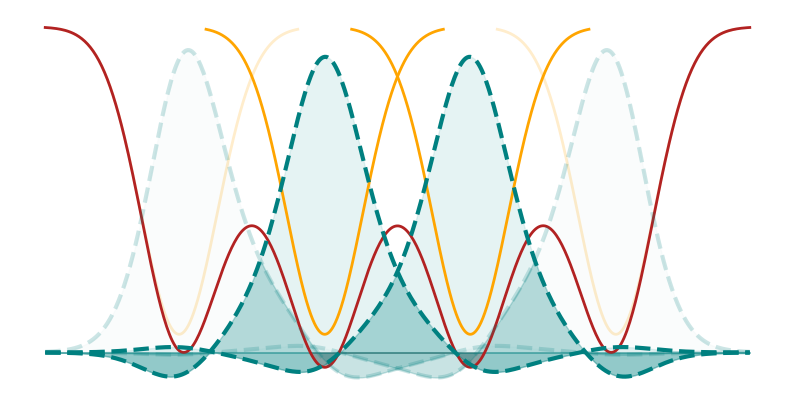

In [13]:
from matplotlib.figure import figaspect
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
edge = 0.65
wf_scale = 0.8
pwr = 2

y = np.array([0])
z = np.array([0])
taillen = 1.1

# Plot total potential
x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
X = np.meshgrid(x, y, z, indexing="ij")
v = dvr.Vfun(*X) ** pwr
v = -abs(v[:, 0, 0])
vmin = np.min(v[:180])
vi_scale = -1

# Plot single traps
for i in range(dvr.lattice.N):
    opacity = 1
    if i in [0, dvr.lattice.N - 1]:
        opacity /= 5
    shift = dvr.trap_centers[i]
    dvr.update_waist(dvr.waists[i])
    x = np.linspace(shift[0] - taillen, shift[0] + taillen, 500)
    X = np.meshgrid(x, y, z, indexing="ij")
    vi = dvr.Voff[i] * DVR.Vfun(dvr, X[0] - shift[0], X[1] - shift[1], X[2]) ** pwr
    plt.plot(
        x,
        vi_scale * abs(vi[:, 0, 0]),
        "-",
        label="V",
        lw=2,
        color="orange",
        alpha=opacity,
    )

x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
plt.plot(x, v, "-", label="V", lw=2, color="firebrick")
plt.fill_between(x[v < vmin], vmin, v[v < vmin], color="firebrick", alpha=0.3)

wf = wf_scale * fix_phase(wannier_func([x, y, z], U, dvr, W, p)[:, 0, 0, :]) + vmin
for i in range(dvr.lattice.N):
    shade_alpha = 0.1
    line_alpa = 1
    line_shape = "--"
    if i in [0, dvr.lattice.N - 1]:
        shade_alpha /= 5
        line_alpa /= 5
    plt.plot(
        x,
        wf[:, i],
        line_shape,
        lw=3,
        color="teal",
        label=f"$w_{i + 1}(x)$",
        alpha=line_alpa,
    )
    plt.fill_between(x, vmin, wf[:, i], color="darkcyan", alpha=shade_alpha)
for i in dvr.lattice.links:
    plt.fill_between(
        x,
        vmin,
        np.min(np.array([wf[:, i[0]], wf[:, i[1]]]), axis=0),
        color="teal",
        alpha=0.2,
    )

plt.xlabel("dx")
plt.axis("off")
plt.savefig("fig1d.svg", transparent=True, bbox_inches="tight")


### Waist by strobe

In [7]:
from Hubbard.equalizer import *
import numpy as np
from tools.fix_phase import fix_phase
import numpy.linalg as la

N = 20
L = 2
R0 = np.array([3, 3, 7.2])
dvr = HubbardEqualizer(
    N,
    R0=R0,
    lattice=np.array([L], dtype=int),
    trap=(50, 1000),
    lc=(500,),
    dim=1,
    equalize_V0=False,
    sparse=True,
    symmetry=True,
    verbosity=0,
)

# E, W, parity = dvr.eigen_basis()
# E = E[0]
# W = W[0]
# p = parity[0]

# A, U = singleband_WF(dvr, E, W, p)
# print('detU =', la.det(U))
# V = singleband_interaction(dvr, U, U, W, W, p,  p)
# print(dvr.R0[0])


Lattice: lattice shape is square; lattice constants set to: (500, 500)
Equalize: scale_factor is not a number. Set to None.
Equalize: ghost sites are set.


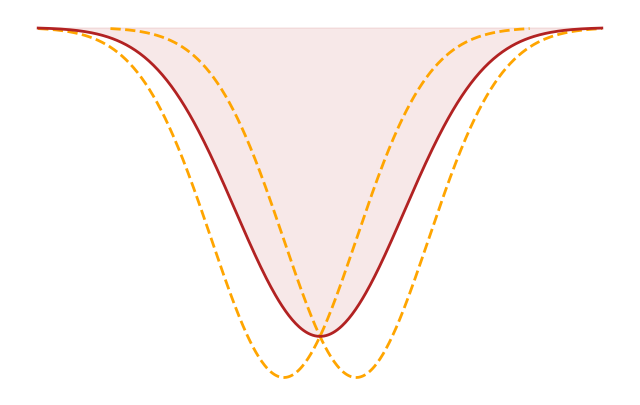

In [8]:
from matplotlib.figure import figaspect
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
edge = 0.6
wf_scale = 0.8

y = np.array([0])
z = np.array([0])
taillen = 1.7

# Plot total potential
x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
X = np.meshgrid(x, y, z, indexing="ij")
v = dvr.Vfun(*X)
v = -abs(v[:, 0, 0]) / 2
vmin = np.min(v[:180])
vmmin = np.min(v)
vi_scale = -1

# Plot single traps
for i in range(dvr.lattice.N):
    opacity = 1
    shift = dvr.trap_centers[i]
    dvr.update_waist(dvr.waists[i])
    x = np.linspace(shift[0] - taillen, shift[0] + taillen, 500)
    X = np.meshgrid(x, y, z, indexing="ij")
    vi = dvr.Voff[i] * DVR.Vfun(dvr, X[0] - shift[0], X[1] - shift[1], X[2])
    plt.plot(x, -abs(vi[:, 0, 0]), "--", label="V", lw=2, color="orange", alpha=opacity)


x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
plt.plot(x, v, "-", label="V", lw=2, color="firebrick")
plt.fill_between(x, 0, v, color="firebrick", alpha=0.1)

plt.xlabel("dx")
plt.axis("off")
plt.savefig("waist.svg", transparent=True, bbox_inches="tight")


In [4]:
from Hubbard.equalizer import *
import numpy as np
from tools.fix_phase import fix_phase
import numpy.linalg as la

N = 20
L = 2
R0 = np.array([3, 3, 7.2])
dvr = HubbardEqualizer(
    N,
    R0=R0,
    lattice=np.array([L], dtype=int),
    trap=(50, 1000),
    lc=(2000,),
    dim=1,
    equalize_V0=False,
    sparse=True,
    symmetry=True,
    verbosity=0,
)

# E, W, parity = dvr.eigen_basis()
# E = E[0]
# W = W[0]
# p = parity[0]

# A, U = singleband_WF(dvr, E, W, p)
# print('detU =', la.det(U))
# V = singleband_interaction(dvr, U, U, W, W, p,  p)
# print(dvr.R0[0])


Lattice: lattice shape is square; lattice constants set to: (2000, 2000)
Equalize: scale_factor is not a number. Set to None.
Equalize: ghost sites are set.


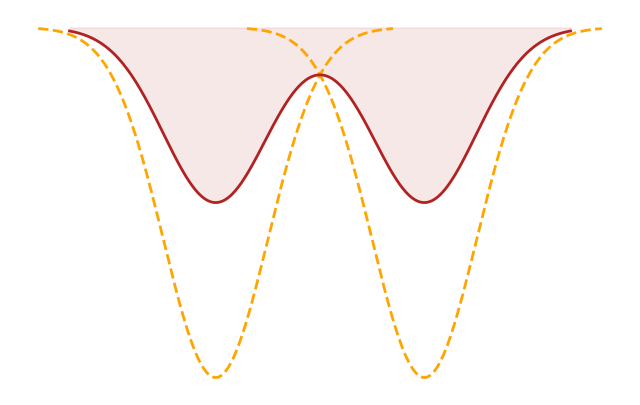

In [6]:
from matplotlib.figure import figaspect
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
edge = 0.6
wf_scale = 0.8

y = np.array([0])
z = np.array([0])
taillen = 1.7

# Plot total potential
x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
X = np.meshgrid(x, y, z, indexing="ij")
v = dvr.Vfun(*X)
v = -abs(v[:, 0, 0]) / 2
vmin = np.min(v[:180])
vmmin = np.min(v)
vi_scale = -1

# Plot single traps
for i in range(dvr.lattice.N):
    opacity = 1
    shift = dvr.trap_centers[i]
    dvr.update_waist(dvr.waists[i])
    x = np.linspace(shift[0] - taillen, shift[0] + taillen, 500)
    X = np.meshgrid(x, y, z, indexing="ij")
    vi = dvr.Voff[i] * DVR.Vfun(dvr, X[0] - shift[0], X[1] - shift[1], X[2])
    plt.plot(x, -abs(vi[:, 0, 0]), "--", label="V", lw=2, color="orange", alpha=opacity)


x = np.linspace(-dvr.R0[0] * edge, dvr.R0[0] * edge, 500)
plt.plot(x, v, "-", label="V", lw=2, color="firebrick")
plt.fill_between(x, 0, v, color="firebrick", alpha=0.1)

plt.xlabel("dx")
plt.axis("off")
plt.savefig("intraband.svg", transparent=True, bbox_inches="tight")
